# Heart Disease UCI

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. The "goal" field refers to the presence of heart disease in the patient. It is integer valued from 0 (no presence) to 4.

Can we find a corrleation between the features and the presence of heart dieases?

## Features descriptions

Attribute Information: 
- 1. age: age
- 2. sex: sex
- 3. cp: chest pain type (4 values) 
- 4. trespbps: resting blood pressure 
- 5. chol: serum cholestoral in mg/dl 
- 6. fbs: fasting blood sugar > 120 mg/dl
- 7. restecg: resting electrocardiographic results (values 0,1,2)
- 8. thalach: maximum heart rate achieved 
- 9. exang: exercise induced angina 
- 10. oldpeak: ST depression induced by exercise relative to rest 
- 11. slope: the slope of the peak exercise ST segment 
- 12. ca: number of major vessels (0-3) colored by flourosopy 
- 13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

## Imports and configurations

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
defaultcolor = '#66ccff'
pd.options.display.float_format = '{:.2f}'.format
rc={'savefig.dpi': 75, 'figure.autolayout': False, 'figure.figsize': [12, 8], 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'lines.linewidth': 2.0, 'lines.markersize': 8, 'legend.fontsize': 16,\
   'xtick.labelsize': 16, 'ytick.labelsize': 16}
sns.set(style='ticks',rc=rc)
sns.set_palette('husl')

## Overall look at the data trying to find any quick insight

In [2]:
df = pd.read_csv('../input/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.30,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.50,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.40,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.80,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.60,2,0,2,1


In [3]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00,303.00
mean,54.37,0.68,0.97,131.62,246.26,0.15,0.53,149.65,0.33,1.04,1.40,0.73,2.31,0.54
std,9.08,0.47,1.03,17.54,51.83,0.36,0.53,22.91,0.47,1.16,0.62,1.02,0.61,0.50
min,29.00,0.00,0.00,94.00,126.00,0.00,0.00,71.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.50,0.00,0.00,120.00,211.00,0.00,0.00,133.50,0.00,0.00,1.00,0.00,2.00,0.00
50%,55.00,1.00,1.00,130.00,240.00,0.00,1.00,153.00,0.00,0.80,1.00,0.00,2.00,1.00
75%,61.00,1.00,2.00,140.00,274.50,0.00,1.00,166.00,1.00,1.60,2.00,1.00,3.00,1.00
max,77.00,1.00,3.00,200.00,564.00,1.00,2.00,202.00,1.00,6.20,2.00,4.00,3.00,1.00


Let's try to get quick insights about the data

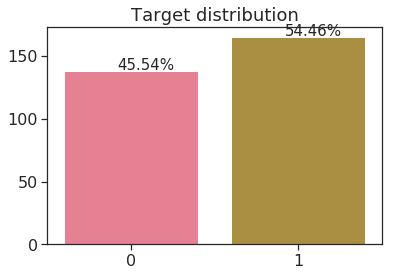

In [4]:
fig, ax = plt.subplots()
sns.countplot(df.target, ax=ax)
for i,p in enumerate(ax.patches):
    ax.annotate('{:.2f}%'.format(df['target'].value_counts().apply(lambda x: 100*x/df['target'].value_counts().sum())[i]), (p.get_x()+0.32, p.get_height()+1)).set_fontsize(15)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Target distribution");

We have a farely well distrubited dataset so we won't have to worry to much with the model "remebering" the train targets.

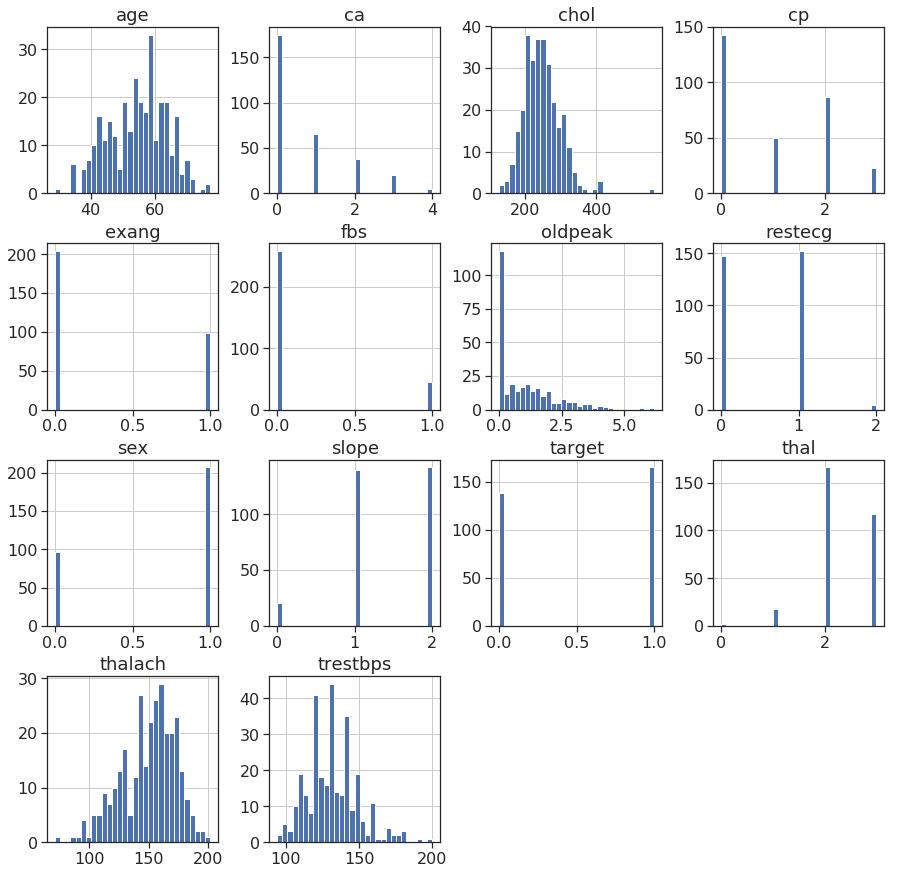

In [5]:
fig, ax = plt.subplots(figsize=[15,15])
df.hist(ax=ax, bins=30, color='b');

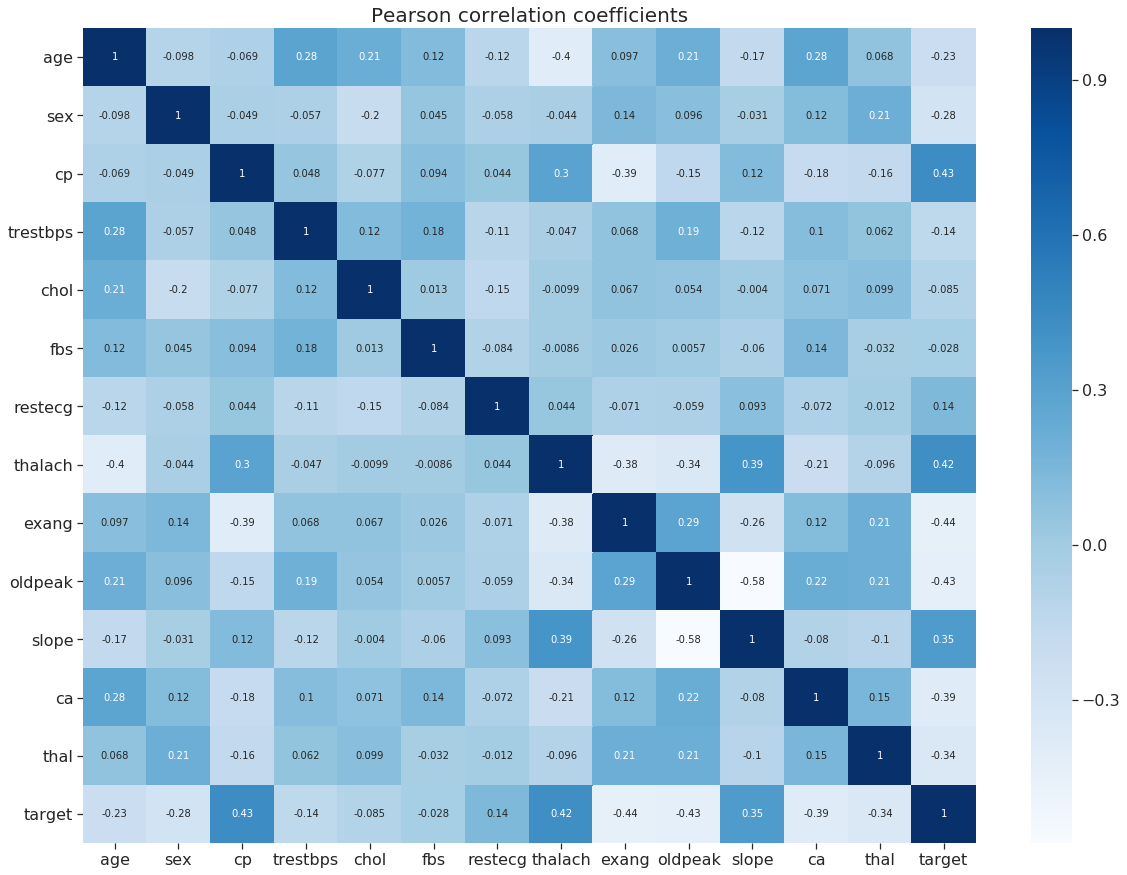

In [6]:
fig, ax = plt.subplots(figsize=[20,15])
sns.heatmap(df.corr(), ax=ax, cmap='Blues', annot=True);
ax.set_title("Pearson correlation coefficients", size=20);

## Exploratory data analysis

### Age distribution

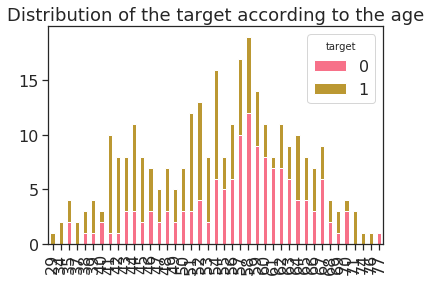

In [7]:
fig, ax = plt.subplots()
df.groupby(['age', 'target']).size().reset_index().pivot(index='age', columns='target', values=0).fillna(0).plot.bar(stacked=True, ax=ax)
ax.set_title("Distribution of the target according to the age")
ax.set_xlabel("");

First thing that can be noticed is that for ages between 40 and 50 the proportion of target=1 is pretty high comparing to pepole with ages ranging from 57 to 67. 

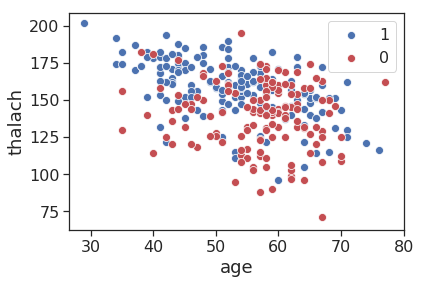

In [8]:
fig, ax = plt.subplots()
sns.scatterplot(x='age', y='thalach', data=df[df.target==1], color='b', ax=ax)
sns.scatterplot(x='age', y='thalach', data=df[df.target==0], color='r', ax=ax)
ax.legend(['1', '0']);

We can see we have a good separtion here between 1 and 0, which is good for our model.

### Target and cp

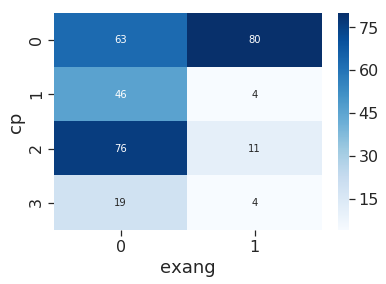

In [9]:
sns.heatmap(df.groupby(['exang', 'cp']).size().reset_index().pivot(columns='exang', index='cp', values=0), cmap='Blues', fmt='g', annot=True);

### Slope and thalach correlation

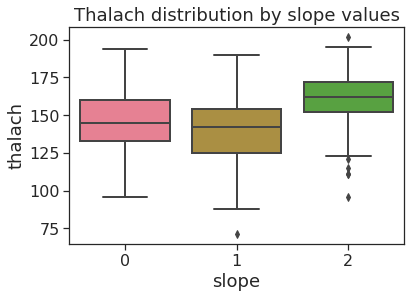

In [10]:
fig, ax = plt.subplots()
sns.boxplot(x='slope', y='thalach', data=df, ax=ax);
ax.set_title("Thalach distribution by slope values");

Looks like we don't have a big difference between 0 and 1 but when slope=2 the thalach distribution get's narrower and higher.

### Thalach and cp

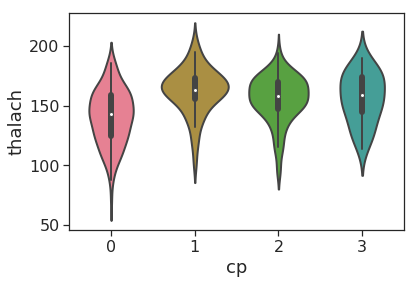

In [11]:
sns.violinplot(x='cp', y='thalach', data=df);

### Slope and oldpeak

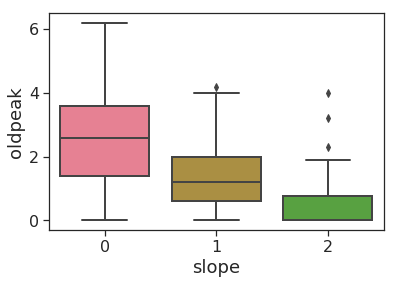

In [12]:
sns.boxplot(x='slope', y='oldpeak', data=df);

We can see a clear correlation between these two features, why is that?

After searching around in the internet we can found out that both of them are metrics to evaluate the ST segment and having an low oldpeak means you probably will have a high slope.

There is a lot of bilbiography on the internet about those features. 

Here is a figure representing the ST segment.

<img src='https://www.teachingmedicine.com/media/lessons/images/Screen%20Shot%202014-06-01%20at%204_12_09%20PM.png'></img>

<p>Extracted from <a href='https://www.teachingmedicine.com/Lesson.aspx?l_id=139'>teachingmedicine</a></p>

## Baseline models

#### Let's first split into training and testing and create a dictionary with the most common models

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df.target, test_size=0.2, random_state=56)

In [14]:
models = {
    'CART': DecisionTreeClassifier(),
    'SVC': SVC(probability=True),
    'GNB': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'LR': LogisticRegression(),
    'KNN': KNeighborsClassifier()
}

#### Some useful functions

In [15]:
def cv_report(models, X, y):
    results = []
    for name in models.keys():
        model = models[name]
        scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        print("Accuracy: %.3f (+/- %.3f) [%s]" %(scores.mean(), scores.std(), name))

In [16]:
cv_report(models, X_train, y_train)

Accuracy: 0.756 (+/- 0.024) [CART]
Accuracy: 0.545 (+/- 0.005) [SVC]
Accuracy: 0.773 (+/- 0.053) [XGB]
Accuracy: 0.822 (+/- 0.028) [GNB]
Accuracy: 0.826 (+/- 0.043) [LDA]
Accuracy: 0.835 (+/- 0.035) [LR]
Accuracy: 0.636 (+/- 0.043) [KNN]


As we can see the baseline models already had a good performance, let's try to improve them.

#### Hyperparameters tunneling using gridsearch

##### XGBoost

In [17]:
# xgb_params = {
#     'max_depth': [2,3,4],
#     'n_estimators': [50, 100, 400, 1000],
#     'learning_rate': [0.1, 0.01, 0.05]
# }

# xg_grid = GridSearchCV(models['XGB'], xgb_params, cv=5)
# models['XGB_Grid'] = xg_grid

In [18]:
cv_report(models, X_train, y_train)

Accuracy: 0.748 (+/- 0.046) [CART]
Accuracy: 0.545 (+/- 0.005) [SVC]
Accuracy: 0.773 (+/- 0.053) [XGB]
Accuracy: 0.822 (+/- 0.028) [GNB]
Accuracy: 0.826 (+/- 0.043) [LDA]
Accuracy: 0.835 (+/- 0.035) [LR]
Accuracy: 0.636 (+/- 0.043) [KNN]
Accuracy: 0.793 (+/- 0.060) [XGB_Grid]


##### Logistic Regression

In [19]:
lr_params = [{
                'penalty': ['l2'],
                'C': (0.1, 0.5, 1.0, 1.5, 2.0),
                'solver': ['newton-cg', 'lbfgs', 'sag'],
                'max_iter': [50, 100, 200, 500]
            },
            {
                'penalty': ['l1', 'l2'],
                'C': (0.1, 0.5, 1.0, 1.5, 2.0),
                'solver': ['liblinear', 'saga']
            }
]

lr_grid = GridSearchCV(models['LR'], lr_params, cv=5)
models['LR_Grid'] = lr_grid

In [20]:
cv_report(models, X_train, y_train)

Accuracy: 0.748 (+/- 0.023) [CART]
Accuracy: 0.545 (+/- 0.005) [SVC]
Accuracy: 0.773 (+/- 0.053) [XGB]
Accuracy: 0.822 (+/- 0.028) [GNB]
Accuracy: 0.826 (+/- 0.043) [LDA]
Accuracy: 0.835 (+/- 0.035) [LR]
Accuracy: 0.636 (+/- 0.043) [KNN]
Accuracy: 0.793 (+/- 0.060) [XGB_Grid]
Accuracy: 0.835 (+/- 0.034) [LR_Grid]


Let's use the tunneled LR for predicting in the test set

In [21]:
models['LR_Grid'].fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'penalty': ['l2'], 'C': (0.1, 0.5, 1.0, 1.5, 2.0), 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [50, 100, 200, 500]}, {'penalty': ['l1', 'l2'], 'C': (0.1, 0.5, 1.0, 1.5, 2.0), 'solver': ['liblinear', 'saga']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
predictions = models['LR_Grid'].predict(X_test)

In [23]:
print("Accuracy of the model: {:.2f}%".format(100*accuracy_score(predictions, y_test)))

Accuracy of the model: 85.25%


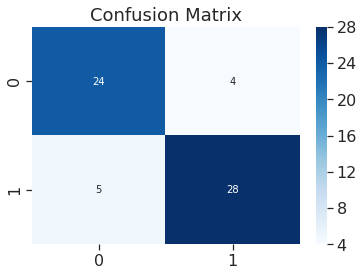

In [24]:
fig, ax = plt.subplots()
ax.set_title("Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap='Blues');